In [ ]:
import os
import cv2
from tqdm import tqdm
import numpy as np
from random import shuffle
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMG_SIZE = 100
NUM_FRAMES = 10

In [ ]:
OUTPUTFILEPATH ="./HockeyValidationDataset2/"
 
violenceIndicator ='fi'
nonViolenceIndicator = 'no'
 
if not os.path.exists(OUTPUTFILEPATH):
    os.mkdir(OUTPUTFILEPATH)

In [ ]:
#Video Frame Extraction
def extractFrames(folder):
 
    if os.path.exists(folder) == False:
        print(str(folder) + " not found")
        return;
 
    c =0
    for files in tqdm(os.listdir(folder)):
        path = os.path.join(folder, files)
        cap = cv2.VideoCapture(path)
 
        success = True
 
        while success:
            success, image = cap.read()
 
            # RGB_img =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
            RGB_img = image
 
            if not success:
                break
 
            if (violenceIndicator in files):
                if not os.path.exists(OUTPUTFILEPATH + "/" + violenceIndicator):
                    os.mkdir(OUTPUTFILEPATH + "/" + violenceIndicator +"/")
 
                cv2.resize(cv2.imwrite(OUTPUTFILEPATH + "/" + violenceIndicator+ "/"+ str(c) + '.jpg', RGB_img), (IMG_SIZE, IMG_SIZE))
            else:
                if not os.path.exists(OUTPUTFILEPATH + "/" + nonViolenceIndicator):
                    os.mkdir(OUTPUTFILEPATH + "/" + nonViolenceIndicator +"/")
                    
                cv2.resize(cv2.imwrite(OUTPUTFILEPATH + "/" + nonViolenceIndicator+ "/"+ str(c) + '.jpg', RGB_img), (IMG_SIZE, IMG_SIZE))
 
            c +=1
    print(c)
    print("Done with file extraction")

In [ ]:
#dataset generation
def GenerateDataset():
    dataset = []
    images = []
    limit = 0
    
    violenceFilePath = OUTPUTFILEPATH + violenceIndicator +"/"
    nonViolenceFilePath = OUTPUTFILEPATH + nonViolenceIndicator + "/"
 
    for frames in tqdm(os.listdir(violenceFilePath)):
        path = os.path.join(violenceFilePath, frames)
        img = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
 
        images.append(np.array(img))
        limit +=1
    
 
        if limit == NUM_FRAMES:
            limit = 0
            dataset.append(np.array([images, np.array([0, 1])]))
            images = []
 
    for frames in tqdm(os.listdir(nonViolenceFilePath)):
        path = os.path.join(nonViolenceFilePath, frames)
        img = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
 
        images.append(np.array(img))
        limit +=1
    
 
        if limit == NUM_FRAMES:
            limit = 0
            dataset.append(np.array([images, np.array([1, 0])]))
            images = []
 
 
    print("Dataset Count " + str(len(dataset)))
    shuffle(dataset)
    np.save('datasetCNN.npy', dataset)
    return dataset

In [ ]:
#Assign Extracted Data

#__Extract frames from data____
extractFrames("./drive/MyDrive/hockeyDataSetUnfixed/dataset")

data = GenerateDataset()

#Uncomment if data has been extracted
#data = np.load('datasetCNN.npy', allow_pickle=True)

#print(data)

100%|██████████| 90/90 [02:48<00:00,  1.87s/it]


16610
Done with file extraction


100%|██████████| 10060/10060 [01:03<00:00, 157.19it/s]


Dataset Count 1661


In [ ]:
X = np.array([i[0] for i in data]).reshape(-1, NUM_FRAMES, IMG_SIZE, IMG_SIZE, 3)
y = np.array([i[1] for i in data])

X = X.astype('float32')

X /= 255

print("Validation sample size = " +str(len(X)))
print("Shape = " + str( X.shape))
print("Y sample size" + str(len(y)))

Validation sample size = 1661
Shape = (1661, 10, 100, 100, 3)
Y sample size1661


[0 1]
<built-in function array>


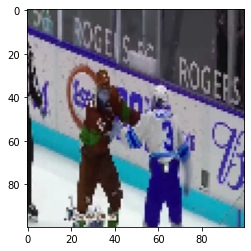

In [ ]:
num = 166
visible_frame = X[num]
visible_frame =  np.array(visible_frame).reshape(10,100,100,3)
 
plt.imshow(visible_frame[0])
print(y[num])
print(np.array)

In [ ]:
classifier = load_model("./drive/MyDrive/BiLstMNet.h5")

classifier.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 100, 100, 64)  1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 98, 98, 64)    36928     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 49, 49, 64)    0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 49, 49, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 47, 47, 64)    36928     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 23, 23, 64)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 23, 23, 64)    0

In [ ]:
score = classifier.evaluate(X, y, verbose =0)

print('Test loss', score[0])
print('Test accuracy', score[1])

Test loss 3.3169291019439697
Test accuracy 0.47140276432037354


In [ ]:
def showModelTest(input_value, prediction):
  print("Prediction= " + str(prediction))
  if (prediction[0][0] > prediction[0][1]):
    print("No violence here")
  else:
    print("Violence Present")
  plt.imshow(input_value)

Label = [1 0]
Prediction= [[0.04724681 0.9111096 ]]
Violence Present


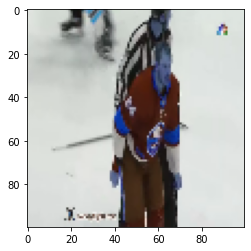

In [ ]:
rand = np.random.randint(0, len(X))
#rand = 2206
input_v = X[rand]
#print(input_v.shape)
#print(y.shape)
print("Label = " + str(y[rand]))

input_v = input_v[0].reshape(100,100,3)

#print(X[rand].shape)
#print(X.shape);
val = X[rand].reshape(1,10,100,100,3)

result = classifier.predict(val, 1,  verbose = 0)

#print(result)

#Display result
showModelTest(input_v, result)

In [ ]:
train, test = train_test_split(data, train_size=0.4, shuffle=True)

# print(train[0][1])
# print(train[1][1])


X = np.array([i[0] for i in train]).reshape(-1, NUM_FRAMES, IMG_SIZE, IMG_SIZE, 3)
y = np.array([i[1] for i in train])

x_valid = np.array([i[0] for i in test]).reshape(-1, NUM_FRAMES, IMG_SIZE, IMG_SIZE, 3)
y_valid = np.array([i[1] for i in test])

X = X.astype('float32')
x_valid = x_valid.astype('float32')

X /= 255
x_valid /=255

#print(X)
print("Training sample size = " +str(len(X)))
print("Testing sample size = " +str(len(x_valid)))
print(x_valid.shape)
print(y[0])
print(len(y))


Training sample size = 917
Testing sample size = 1376
(1376, 10, 100, 100, 3)
[0 1]
917


In [ ]:
#clear up memory
del data
del visible_frame
del input_v
del score
del val
del result
gc.collect()

3847

In [ ]:
#Model Training
BATCH_SIZE = 5
EPOCHS = 50

history = classifier.fit(X, y, batch_size=BATCH_SIZE, epochs= EPOCHS, verbose=1, validation_data=(x_valid,y_valid))


Epoch 1/50
184/184 [==============================] - 30s 137ms/step - loss: 0.5545 - accuracy: 0.7186 - val_loss: 0.3213 - val_accuracy: 0.8859
Epoch 2/50
184/184 [==============================] - 23s 127ms/step - loss: 0.3273 - accuracy: 0.8615 - val_loss: 0.2609 - val_accuracy: 0.9128
Epoch 3/50
184/184 [==============================] - 23s 126ms/step - loss: 0.2646 - accuracy: 0.8986 - val_loss: 0.2651 - val_accuracy: 0.8837
Epoch 4/50
184/184 [==============================] - 23s 127ms/step - loss: 0.1827 - accuracy: 0.9280 - val_loss: 1.4640 - val_accuracy: 0.5218
Epoch 5/50
184/184 [==============================] - 23s 127ms/step - loss: 0.1921 - accuracy: 0.9378 - val_loss: 0.1847 - val_accuracy: 0.9419
Epoch 6/50
184/184 [==============================] - 23s 127ms/step - loss: 0.1544 - accuracy: 0.9520 - val_loss: 0.1174 - val_accuracy: 0.9593
Epoch 7/50
184/184 [==============================] - 23s 126ms/step - loss: 0.1808 - accuracy: 0.9411 - val_loss: 0.1238 - val_ac

In [ ]:

classifier.save("SavedFirst/BiLstMNetExtraTrain.h5");
print("Saved Model");

Saved Model


In [ ]:
score = classifier.evaluate(x_valid, y_valid, verbose =0)
print('Test loss', score[0])
print('Test accuracy', score[1])

Test loss 0.03968243673443794
Test accuracy 0.9861918687820435


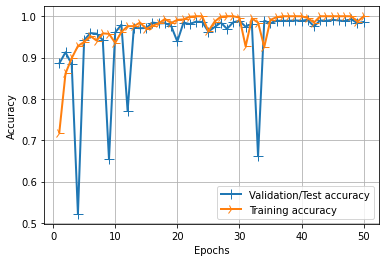

In [ ]:
history_dict = history.history;

acc_value = history_dict['accuracy'];
val_acc_value = history_dict['val_accuracy'];
epoch = range(1,len(acc_value) + 1);

line1 =plt.plot(epoch, val_acc_value, label="Validation/Test accuracy");
line2 =plt.plot(epoch, acc_value, label="Training accuracy");

plt.setp(line1, linewidth=2.0, marker ='+', markersize = 10.0);
plt.setp(line2, linewidth=2.0, marker ='4', markersize = 10.0);

plt.xlabel('Epochs');
plt.ylabel('Accuracy');
plt.grid(True);
plt.legend()

plt.show();

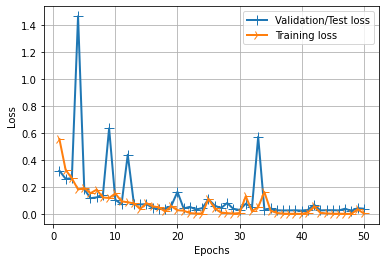

In [ ]:
history_dict = history.history;

loss_value = history_dict['loss'];
val_loss_value = history_dict['val_loss'];
epoch = range(1,len(loss_value) + 1);

line1 =plt.plot(epoch, val_loss_value, label="Validation/Test loss");
line2 =plt.plot(epoch, loss_value, label="Training loss");

plt.setp(line1, linewidth=2.0, marker ='+', markersize = 10.0);
plt.setp(line2, linewidth=2.0, marker ='4', markersize = 10.0);

plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.grid(True);
plt.legend()

plt.show();

In [ ]:
rand = np.random.randint(0, len(x_valid))
#rand = 2206
input_v = x_valid[rand]
#print(input_v.shape)
#print(y_valid.shape)
print("Label = " + str(y_valid[rand]))

input_v = input_v[0].reshape(100,100,3)

#print(x_valid[rand].shape)
#print(x_valid.shape);
val = x_valid[rand].reshape(1,10,100,100,3)

result = classifier.predict(val, 1,  verbose = 0)

#print(result[0][1])

#Display result
showModelTest(input_v, result)

NameError: ignored